In [32]:
from pathlib import Path

import numpy as np

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm

import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn


In [2]:
import sys
sys.version

'3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]'

### Open dataset and detect column types: numerical, categorical, and target

In [8]:
DATASETS_DIR = Path('../data')
ADULT_DATASET = DATASETS_DIR / 'adult-census-income' / 'adult-processed.csv'

In [9]:
df = pd.read_csv(ADULT_DATASET)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
len(df) / 5

6512.2

In [10]:
df = df.rename(columns=lambda x: x.strip().replace(' ', ''))

In [11]:
df.shape

(32561, 15)

In [12]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [6]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = 'plotly'
pio.kaleido.scope.default_width = 1200

In [11]:

fig = make_subplots(rows=1, cols=2)

labels = list(df['sex'].unique())

traces = []

for i in range(2):

    tmp = df.loc[df['income'] == i]

    v = list(map(lambda l: len(tmp.loc[tmp['sex'] == l]), labels))

    print(v)

    trace = go.Pie(labels=labels, values=v,
                   domain=dict(x=[0.5 * i, 0.5 * (i + 1)]),
                   title=target_encoder.classes_[i])

    traces.append(trace)


fig = go.Figure(data=traces,
                layout=go.Layout(title='Income',
                                 width=1200,
                                 height=800))


fig.show()

[0, 0]
[0, 0]


In [36]:
fig.write_image('../images/adult-exploration/models-to-predict-sex.png',
                scale=2)

In [15]:
fig = px.histogram(df,
             x='income',
             color='sex',
             barmode='group',
             template='plotly_white')
fig.show()

<AxesSubplot:>

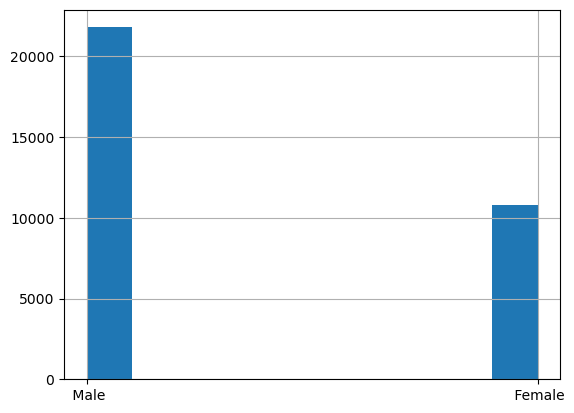

In [22]:
df['sex'].hist()

In [20]:
target_col = 'income'
protected_cols = ['race', 'sex', 'native-country', 'age']
categorical_cols = df.select_dtypes(object).drop(columns=protected_cols+[target_col], errors='ignore').columns
numerical_cols = df.select_dtypes(exclude=object).drop(columns=protected_cols+[target_col], errors='ignore').columns

# Relationship of variables with the sex variable

In [39]:
cor_df = pd.get_dummies(df, drop_first=True).corr()
cor_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income_ >50K
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.051227,0.060901,-0.019362,-0.198388,...,0.008374,0.002583,0.000613,-0.013816,-0.006271,0.004843,0.015917,-1.505357e-02,0.000375,0.234037
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768,-0.007525,-0.002828,0.005031,0.042907,...,0.007164,-0.003790,-0.012365,-0.001252,-0.001250,0.005273,-0.075287,-1.139827e-02,0.005501,-0.009463
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123,0.060518,0.097941,-0.015117,-0.118484,...,-0.041269,0.001264,0.016046,0.049472,0.007896,-0.017071,0.101207,-7.483035e-03,-0.001234,0.335154
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409,-0.005768,-0.007007,-0.002140,-0.038701,...,-0.006103,-0.001680,0.005323,0.005735,-0.003432,-0.003526,0.004599,-2.564276e-03,-0.002193,0.223329
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256,0.010798,0.014668,-0.003177,-0.027460,...,-0.004718,-0.004160,0.010114,0.006637,-0.005095,0.008102,0.008784,-5.997599e-07,-0.004804,0.150526


In [44]:
var = 'sex_ Male'

cor_df_var = cor_df[var]
cor_df_var = cor_df_var.sort_values(ascending=False)[1:11]

fig = px.bar(cor_df_var,
             template='plotly_white',
             title=f'Ten most correlated variables with {var}')
fig.update_layout(xaxis={'title': ''},
                  yaxis={'title': 'correlation'},
                  showlegend=False)

fig.show()

In [32]:
cor_df_var.sort_values(ascending=False)[1:11]

marital-status_ Married-civ-spouse    0.431805
hours-per-week                        0.229309
occupation_ Craft-repair              0.223128
income_ >50K                          0.215980
occupation_ Transport-moving          0.132468
workclass_ Self-emp-not-inc           0.107451
race_ White                           0.103486
occupation_ Farming-fishing           0.100097
occupation_ Handlers-cleaners         0.094026
age                                   0.088832
Name: sex_ Male, dtype: float64

## Model to predict sex

In [17]:
df_input = df[categorical_cols]
df_input_dummies = pd.get_dummies(df_input, drop_first=True).to_numpy()

le = LabelEncoder()
sex_values = le.fit_transform(df['sex'])


In [21]:

X_train_sex, X_test_sex, y_train_sex, y_test_sex = train_test_split(df_input_dummies, sex_values, test_size=0.2, shuffle=True)


In [29]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [32]:
# model = LogisticRegression()
model = MLPClassifier(hidden_layer_sizes=(100, 100))
model.fit(X_train_sex, y_train_sex)

MLPClassifier(hidden_layer_sizes=(100, 100))

In [33]:
accuracy_score(y_test_sex, model.predict(X_test_sex))

0.828036235221864

In [24]:
y_test_sex.mean()

0.6680485183479196

In [35]:

tmp_df = pd.DataFrame(
    data={
        'model': ['random guess', 'logistic regression', 'svc', 'decision tree', 'neural network'],
        'test accuracy': [0.6680485183479196, 0.8347919545524336, 0.8392445877475817, 0.8269614616920006, 0.828036235221864]
    }
)

fig = px.bar(
    tmp_df,
    x='model',
    y='test accuracy',
    template='plotly_white'
)

fig.show()



In [42]:
px.histogram(
    df,
    x='age'
)

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'capital-gain'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

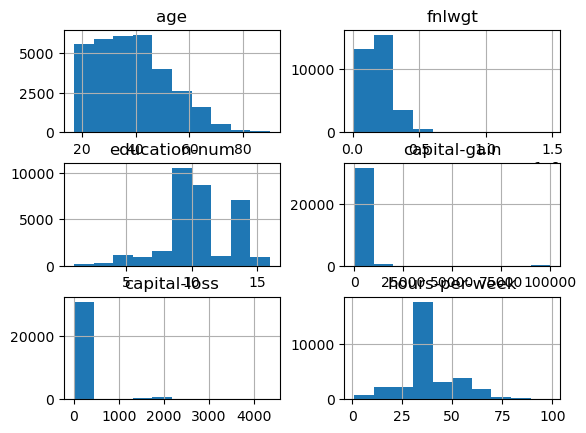

In [37]:
df.hist()

### Process numerical columns: scale

In [13]:
scaler = StandardScaler()

In [21]:
df_num = pd.DataFrame(
    scaler.fit_transform(df[numerical_cols]),
    index=df[numerical_cols].index,
    columns=df[numerical_cols].columns
)

In [22]:
df_num.head()

,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-1.063611,1.134739,0.148453,-0.21666,-0.035429
1,-1.008707,1.134739,-0.145920,-0.21666,-2.222153
2,0.245079,-0.420060,-0.145920,-0.21666,-0.035429
3,0.425801,-1.197459,-0.145920,-0.21666,-0.035429
4,1.408176,1.134739,-0.145920,-0.21666,-0.035429


### Process categorical columns: convert to onehot

In [23]:
df_cat = pd.get_dummies(df[categorical_cols].applymap(lambda x: x.strip()), drop_first=True)

In [24]:
df_cat.head()

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,...,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


### Process target

In [15]:
target_encoder = LabelEncoder()

In [16]:
y = target_encoder.fit_transform(df['income'])

In [19]:
type(target_encoder.classes_)

numpy.ndarray

In [17]:
y

array([0, 0, 0, ..., 0, 0, 1])

In [21]:
df['income_old'] = df['income']
df['income'] = y

### Preparation to train

In [25]:
df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
idx_train = df_train.index
idx_test = df_test.index

In [26]:
X_train = np.concatenate(
    (
        df_num.loc[idx_train].to_numpy(),
        df_cat.loc[idx_train].to_numpy()
    ),
    axis=1
)

X_test = np.concatenate(
    (
        df_num.loc[idx_test].to_numpy(),
        df_cat.loc[idx_test].to_numpy()
    ),
    axis=1
)

In [27]:
X_train.shape, X_test.shape

((26048, 53), (6513, 53))

### Baseline model

In [34]:
# base_model = LogisticRegression(max_iter=10000)
# base_model = RandomForestClassifier()
base_model = SVC()
base_model.fit(X_train, y_train)

SVC()

In [35]:
y_test_predict = base_model.predict(X_test)
ac = accuracy_score(y_test, y_test_predict)
ac

0.8575157377552587

In [38]:
1 - y_test.mean()

0.760939659143252

In [21]:
df_test_predicted = df_test.copy()
df_test_predicted['income_pred'] = y_test_predict
df_test_predicted.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,income_pred
13009,50,Private,165050,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K,0
16085,24,State-gov,211049,7th-8th,4,Never-married,Tech-support,Unmarried,White,Female,0,0,20,United-States,<=50K,0
2308,53,Private,149784,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,7688,0,40,United-States,>50K,1
26755,23,Private,265356,Bachelors,13,Never-married,Exec-managerial,Unmarried,White,Male,0,0,40,United-States,<=50K,0
27899,33,Local-gov,300681,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,<=50K,0


In [22]:
def measure_fairness(df, protected_col):

    x_protected = df.loc[:, protected_col].to_numpy()
    x_protected_unique = np.unique(x_protected)

    dfs = pd.DataFrame(index=x_protected_unique)
    dfs.index.name = protected_col

    for protected_value in x_protected_unique:
        y_true = target_encoder.transform(df.loc[df[protected_col] == protected_value, df.columns[-2]].to_numpy())
        y_pred = df.loc[df[protected_col] == protected_value, df.columns[-1]].to_numpy()
        cm = confusion_matrix(y_true, y_pred)
        dfs.loc[protected_value, 'tn'] = cm[0, 0]
        dfs.loc[protected_value, 'fp'] = cm[0, 1]
        dfs.loc[protected_value, 'fn'] = cm[1, 0]
        dfs.loc[protected_value, 'tp'] = cm[1, 1]

    dfs['tpr'] = dfs['tp']/(dfs['tp']+dfs['fn'])
    dfs['fpr'] = dfs['fp']/(dfs['fp']+dfs['tn'])
    dfs['pr'] = dfs['tp']/(dfs['tp']+dfs['fp']+dfs['tn']+dfs['fn'])

    return dfs


In [23]:
df_fairness = measure_fairness(df_test_predicted, 'sex')
df_fairness

,tn,fp,fn,tp,tpr,fpr,pr
sex,,,,,,,
Female,1901.0,52.0,139.0,117.0,0.457031,0.026626,0.052965
Male,2711.0,283.0,498.0,812.0,0.619847,0.094522,0.188662


In [24]:
df[target_col].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

#### Measuring Accuracy Vs. TPR for different thresholds

In [62]:

y_test_prob_predict = base_model.predict_proba(X_test)[:, 1].flatten()

acc = []
tpr = []

for thres in tqdm.tqdm(np.linspace(0, 1, 100)):

    y_test_predict = y_test_prob_predict > thres
    ac = accuracy_score(y_test, y_test_predict)

    df_test_predicted = df_test.copy()
    df_test_predicted['income_pred'] = y_test_predict
    df_fairness = measure_fairness(df_test_predicted, 'sex')['tpr']

    acc.append(ac)
    tpr.append(df_fairness[1]-df_fairness[0])



100%|██████████| 100/100 [00:03<00:00, 26.47it/s]


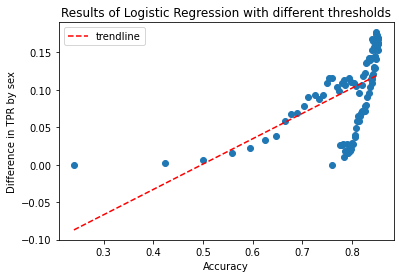

In [67]:
# Create trendline
z = np.polyfit(acc, tpr, 1)
p = np.poly1d(z)

# Plot
plt.figure()
plt.scatter(acc, tpr)
x_axis = np.linspace(min(acc), max(acc), 100)
plt.plot(x_axis, p(x_axis), 'r--', label='trendline')
plt.xlabel('Accuracy')
plt.ylabel('Difference in TPR by sex')
plt.legend()
plt.title('Results of Logistic Regression with different thresholds')
plt.show()

In [64]:
est1 = sm.OLS(tpr, np.stack((np.ones_like(acc), np.array(acc)), axis=1))
est2 = est1.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     55.71
Date:                Wed, 15 Feb 2023   Prob (F-statistic):           3.47e-11
Time:                        08:25:48   Log-Likelihood:                 175.34
No. Observations:                 100   AIC:                            -346.7
Df Residuals:                      98   BIC:                            -341.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1685      0.036     -4.668      0.000      -0.240      -0.097
x1             0.3385      0.045      7.464      0.000       0.249       0.429
==============================================================================
Omnibus:                        8.269   Durbin-Watson:                   0.055
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                7.559
Skew:                          -0.601   Prob(JB):                       0.0228
Kurtosis:                       2.391   Cond. No.                         17.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Baseline model RF

In [68]:
acc = []
tpr = []

for i in tqdm.tqdm(range(100)):

    m = RandomForestClassifier(random_state=i) # K-fold cross validation
    m.fit(X_train, y_train)

    y_test_predict = m.predict(X_test)
    ac = accuracy_score(y_test, y_test_predict)

    acc.append(ac)

    df_test_predicted = df_test.copy()
    df_test_predicted['income_pred'] = y_test_predict
    df_fairness = measure_fairness(df_test_predicted, 'sex')['tpr']

    tpr.append(df_fairness.max()-df_fairness.min())



100%|██████████| 100/100 [05:58<00:00,  3.59s/it]


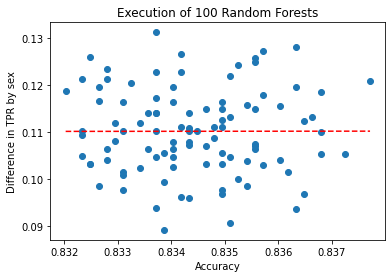

In [69]:
# Create trendline
z = np.polyfit(acc, tpr, 1)
p = np.poly1d(z)

# Plot
plt.figure()
plt.scatter(acc, tpr)
x_axis = np.linspace(min(acc), max(acc), 100)
plt.plot(x_axis, p(x_axis), 'r--')
plt.xlabel('Accuracy')
plt.ylabel('Difference in TPR by sex')
plt.title('Execution of 100 Random Forests')
plt.show()

In [70]:
est1 = sm.OLS(tpr, np.stack((np.ones_like(acc), np.array(acc)), axis=1))
est2 = est1.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                 0.0001493
Date:                Wed, 15 Feb 2023   Prob (F-statistic):              0.990
Time:                        08:37:28   Log-Likelihood:                 328.93
No. Observations:                 100   AIC:                            -653.9
Df Residuals:                      98   BIC:                            -648.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1030      0.587      0.176      0.861      -1.061       1.267
x1             0.0086      0.703      0.012      0.990      -1.387       1.404
==============================================================================
Omnibus:                        1.472   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.479   Jarque-Bera (JB):                1.235
Skew:                           0.076   Prob(JB):                        0.539
Kurtosis:                       2.477   Cond. No.                     1.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Convert to tesors

In [19]:
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

## Models

In [20]:
class MyClassificationModel(nn.Module):

    def __init__(self, n1=512, n2=256, dropout=0.2):
        super(MyClassificationModel, self).__init__()
        self.linear1 = nn.Linear(53, n1)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(n1, n2)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)
        self.linear3 = nn.Linear(n2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.drop1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.drop2(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x


In [21]:

class FairnessLoss(nn.Module):

    def __init__(self, protected_col='sex'):
        self.protected_col = protected_col

    def forward(self, y, protected_values):
        pass



### Objectives

In [22]:
def create_and_train_model(lr, dropout):

    model = MyClassificationModel(dropout=dropout)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), 10 ** -(1+3*lr))

    for i in range(20):
        optimizer.zero_grad()
        y_pred = model(X_train).squeeze(-1)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        print(f'Epoch: {i:>3} | Train loss: {loss:.4f}')

    return model


In [23]:
def objective_accuracy(model):

    model.eval()
    y_pred_test = model(X_test).squeeze(-1).detach()
    return accuracy_score(y_test, y_pred_test.round())


In [59]:
def objective_fairness(model, protected_col='sex'):
    """Diference in the positive rate for protected and non-protected characteristics"""

    protected_series = df_test[protected_col]

    model.eval()
    y_pred_test = model(X_test).squeeze(-1).detach()

    tpr = {}

    df_test_2 = df_test.reset_index()

    for protected_value in protected_series.unique():

        idx_protected_value = df_test_2.loc[df_test_2[protected_col] == protected_value, :].index

        y_true_value = torch.tensor(target_encoder.transform(df_test_2.loc[idx_protected_value, target_col]))
        y_pred_value = y_pred_test.index_select(0, torch.tensor(idx_protected_value, dtype=torch.int)).round()

        true_positives = ((y_true_value == 1) & (y_pred_value == 1)).sum()
        false_negatives = ((y_true_value == 1) & (y_pred_value == 0)).sum()

        tpr[protected_value] = true_positives / (true_positives + false_negatives)

    # print(tpr)

    tpr_values = torch.tensor(list(tpr.values()))
    return (1 - tpr_values.max() + tpr_values.min()).item()


In [56]:
model = create_and_train_model(0.3, 0.2)

Epoch:   0 | Train loss: 0.6875
Epoch:   1 | Train loss: 0.8364
Epoch:   2 | Train loss: 0.4571
Epoch:   3 | Train loss: 0.4713
Epoch:   4 | Train loss: 0.4357
Epoch:   5 | Train loss: 0.3850
Epoch:   6 | Train loss: 0.3603
Epoch:   7 | Train loss: 0.3625
Epoch:   8 | Train loss: 0.3696
Epoch:   9 | Train loss: 0.3645
Epoch:  10 | Train loss: 0.3503
Epoch:  11 | Train loss: 0.3381
Epoch:  12 | Train loss: 0.3332
Epoch:  13 | Train loss: 0.3333
Epoch:  14 | Train loss: 0.3377
Epoch:  15 | Train loss: 0.3397
Epoch:  16 | Train loss: 0.3367
Epoch:  17 | Train loss: 0.3314
Epoch:  18 | Train loss: 0.3267
Epoch:  19 | Train loss: 0.3245


In [57]:
objective_accuracy(model)

0.8478427759864886

In [58]:
objective_fairness(model)

{' Female': tensor(0.5446), ' Male': tensor(0.5285)}


0.9838429093360901

In [60]:
def target_function(hparams):

    model = create_and_train_model(hparams[0], hparams[1])

    obj1 = objective_accuracy(model)
    obj2 = objective_fairness(model)

    return [obj1, obj2]

In [100]:
target_function(torch.tensor([0.3, 0.2]))

Epoch:   0 | Train loss: 0.6913
Epoch:   1 | Train loss: 0.9076
Epoch:   2 | Train loss: 0.4668
Epoch:   3 | Train loss: 0.4845
Epoch:   4 | Train loss: 0.4541
Epoch:   5 | Train loss: 0.3993
Epoch:   6 | Train loss: 0.3664
Epoch:   7 | Train loss: 0.3622
Epoch:   8 | Train loss: 0.3701
Epoch:   9 | Train loss: 0.3686
Epoch:  10 | Train loss: 0.3554
Epoch:  11 | Train loss: 0.3407
Epoch:  12 | Train loss: 0.3319
Epoch:  13 | Train loss: 0.3309
Epoch:  14 | Train loss: 0.3363
Epoch:  15 | Train loss: 0.3407
Epoch:  16 | Train loss: 0.3385
Epoch:  17 | Train loss: 0.3333
Epoch:  18 | Train loss: 0.3275
Epoch:  19 | Train loss: 0.3253


[0.8493781667434362, 0.999665379524231]

# Bayesian Optimization: Eduardo's Notebook


### Imports

In [13]:
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from botorch.models.transforms.outcome import Standardize
from botorch.models import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch import fit_gpytorch_model
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning

### Preparation

In [36]:
bounds = np.array([[0, 0], [1, 0.9]])

In [64]:
def generate_initial_data(n=10):
  train_x = torch.rand(n, len(bounds[0])) * (bounds[1] - bounds[0]) + bounds[0]
  exact_obj = torch.tensor([target_function(sample) for sample in train_x])
  best_observed_value = exact_obj.max().item()
  return train_x, exact_obj, best_observed_value

In [65]:
generate_initial_data(3)

Epoch:   0 | Train loss: 0.7084
Epoch:   1 | Train loss: 0.5755
Epoch:   2 | Train loss: 0.5041
Epoch:   3 | Train loss: 0.4380
Epoch:   4 | Train loss: 0.4041
Epoch:   5 | Train loss: 0.3832
Epoch:   6 | Train loss: 0.3704
Epoch:   7 | Train loss: 0.3604
Epoch:   8 | Train loss: 0.3529
Epoch:   9 | Train loss: 0.3537
Epoch:  10 | Train loss: 0.3526
Epoch:  11 | Train loss: 0.3505
Epoch:  12 | Train loss: 0.3456
Epoch:  13 | Train loss: 0.3382
Epoch:  14 | Train loss: 0.3363
Epoch:  15 | Train loss: 0.3311
Epoch:  16 | Train loss: 0.3290
Epoch:  17 | Train loss: 0.3304
Epoch:  18 | Train loss: 0.3296
Epoch:  19 | Train loss: 0.3284
Epoch:   0 | Train loss: 0.6817
Epoch:   1 | Train loss: 0.5842
Epoch:   2 | Train loss: 0.5411
Epoch:   3 | Train loss: 0.5084
Epoch:   4 | Train loss: 0.4694
Epoch:   5 | Train loss: 0.4337
Epoch:   6 | Train loss: 0.4074
Epoch:   7 | Train loss: 0.3907
Epoch:   8 | Train loss: 0.3799
Epoch:   9 | Train loss: 0.3722
Epoch:  10 | Train loss: 0.3680
Epoch:  

(tensor([[0.4138, 0.5116],
         [0.5071, 0.7357],
         [0.8820, 0.1983]], dtype=torch.float64),
 tensor([[0.8509, 0.9960],
         [0.8509, 0.9385],
         [0.7608, 1.0000]], dtype=torch.float64),
 1.0)

### Optimizer (get next point)

In [66]:
def optimize_qehvi_and_get_observation(model, train_x, train_obj, sampler, bounds, reference_point, normalized_bounds):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles

    with torch.no_grad():
        pred = model.posterior(normalize(train_x, bounds)).mean
    partitioning = FastNondominatedPartitioning(
        ref_point=reference_point,
        Y=pred,
    )
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=reference_point,
        partitioning=partitioning,
        sampler=sampler,
    )

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=normalized_bounds,
        q=1,
        num_restarts=200,
        raw_samples=512,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x =  unnormalize(candidates.detach(), bounds=bounds)
    new_obj = target_function(new_x[0])
    return new_x, new_obj

def get_next_points(init_x, init_y, bounds, reference_point, normalized_bounds, n_points=1):
  train_x = normalize(init_x, bounds)
  models = []
  for i in range(init_y.shape[1]):
    train_y = init_y[..., i:i+1]
    models.append(SingleTaskGP(train_x, train_y, outcome_transform=Standardize(m=1)))
  model = ModelListGP(*models)
  mll = SumMarginalLogLikelihood(model.likelihood, model)
  fit_gpytorch_model(mll)
  qehvi_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([128]))

  configuration, observation = optimize_qehvi_and_get_observation(model, init_x, init_y, qehvi_sampler, bounds, reference_point, normalized_bounds)

  return configuration, observation

### Iterator / Loop

In [12]:
DominatedPartitioning

NameError: name 'DominatedPartitioning' is not defined

In [78]:
n_experiments = 1
n_iterations= 20
n_methods = 2

#We store the results in this tensor, we just have two methods to compare.
experiment_results = np.zeros((n_methods, n_experiments, n_iterations))
experiment_configurations = np.zeros((n_methods, n_experiments, n_iterations, len(bounds[0])))
normalized_bounds = torch.tensor([np.zeros(len(bounds[0])), np.ones(len(bounds[0]))])
bounds = np.array([[0, 0], [1, 0.9]])
reference_point = torch.tensor([0, 0])

for i in range(n_experiments):
  np.random.seed(i)
  torch.manual_seed(i)

  init_x, init_y, best_init_y = generate_initial_data(1)

  candidates = []
  results = []

  best_observed_result_bo = DominatedPartitioning(ref_point=reference_point, Y=init_y).compute_hypervolume().item()
  best_observed_candidate_bo = init_x[0]

  random_sample_hyperparameters = torch.rand(1, len(bounds[0])) * (bounds[1] - bounds[0]) + bounds[0]

  best_observed_result_rs = DominatedPartitioning(ref_point=reference_point, Y=torch.tensor([target_function(random_sample_hyperparameters[0])])).compute_hypervolume().item()
  best_observed_candidate_rs = random_sample_hyperparameters[0]

  for j in range(n_iterations):

    #BO Code.
    new_candidates, new_results = get_next_points(init_x, init_y, bounds, reference_point, normalized_bounds)

    print(f"New candidates are: {new_candidates}")
    init_x = torch.cat([init_x, new_candidates])
    init_y = torch.cat([init_y, torch.tensor([new_results])])

    # compute hypervolume
    bd = DominatedPartitioning(ref_point=reference_point, Y=init_y)
    volume = bd.compute_hypervolume().item()

    if best_observed_result_bo < volume:
      best_observed_result_bo = volume
      best_observed_candidate_bo = new_candidates[0]

    experiment_configurations[0,i,j,:] = best_observed_candidate_bo
    experiment_results[0,i,j] = best_observed_result_bo

    ##RS Code.
    #I sample the hyperparameter value for random search here.
    random_sample_hyperparameters = torch.rand(1, len(bounds[0])) * (bounds[1] - bounds[0]) + bounds[0]
    rs_obj_fun_result = DominatedPartitioning(ref_point=reference_point, Y=torch.tensor([target_function(random_sample_hyperparameters[0])])).compute_hypervolume().item()

    if best_observed_result_rs < rs_obj_fun_result:
      best_observed_result_rs = rs_obj_fun_result
      best_observed_candidate_rs = random_sample_hyperparameters[0]
    experiment_configurations[1,i,j,:] = best_observed_candidate_rs
    experiment_results[1,i,j] = best_observed_result_rs
    print("Current best BO candidate: " + str(best_observed_candidate_bo))
    print("Current best RS candidate: " + str(best_observed_candidate_rs))
    print("Current best BO hypervolume: " + str(best_observed_result_bo))
    print("Current best RS hypervolume: " + str(best_observed_result_rs))
    print(f"Number of iterations done: {(j+1)}")
    print(f"Number of experiment: {(i+1)}")


Epoch:   0 | Train loss: 0.6897
Epoch:   1 | Train loss: 0.5731
Epoch:   2 | Train loss: 0.5305
Epoch:   3 | Train loss: 0.5000
Epoch:   4 | Train loss: 0.4635
Epoch:   5 | Train loss: 0.4301
Epoch:   6 | Train loss: 0.4080
Epoch:   7 | Train loss: 0.3934
Epoch:   8 | Train loss: 0.3824
Epoch:   9 | Train loss: 0.3714
Epoch:  10 | Train loss: 0.3644
Epoch:  11 | Train loss: 0.3595
Epoch:  12 | Train loss: 0.3582
Epoch:  13 | Train loss: 0.3575
Epoch:  14 | Train loss: 0.3548
Epoch:  15 | Train loss: 0.3542
Epoch:  16 | Train loss: 0.3508
Epoch:  17 | Train loss: 0.3495
Epoch:  18 | Train loss: 0.3478
Epoch:  19 | Train loss: 0.3435
Epoch:   0 | Train loss: 0.6973
Epoch:   1 | Train loss: 0.6658
Epoch:   2 | Train loss: 0.6382
Epoch:   3 | Train loss: 0.6139
Epoch:   4 | Train loss: 0.5923
Epoch:   5 | Train loss: 0.5730
Epoch:   6 | Train loss: 0.5557
Epoch:   7 | Train loss: 0.5400
Epoch:   8 | Train loss: 0.5256
Epoch:   9 | Train loss: 0.5120
Epoch:  10 | Train loss: 0.4993
Epoch:  

### Debug

In [69]:
reference_point

tensor([1, 1])

In [14]:
DominatedPartitioning(ref_point=torch.Tensor([0, 0]), Y=torch.Tensor([[0.7, 0.7]])).compute_hypervolume().item()

0.4899999797344208

### Results

In [79]:
best_observed_result = np.max(experiment_results)
index_set = np.where(experiment_results==best_observed_result)
print("The best observed result is: " + str(best_observed_result))
print("The best observed result belong to the : " + str(index_set[0][0]) + " method. Its value is " + str(experiment_configurations[index_set][0]))


The best observed result is: 0.8509366919455139
The best observed result belong to the : 0 method. Its value is [0.17021989 0.34259137]


In [98]:
experiment_configurations

array([[[[1.        , 0.        ],
         [1.        , 0.        ],
         [1.        , 0.        ],
         [1.        , 0.        ],
         [0.45933687, 0.58467077],
         [0.45933687, 0.58467077],
         [0.45933687, 0.58467077],
         [0.45933687, 0.58467077],
         [0.45933687, 0.58467077],
         [0.45933687, 0.58467077],
         [0.45933687, 0.58467077],
         [0.45933687, 0.58467077],
         [0.45933687, 0.58467077],
         [0.45933687, 0.58467077],
         [0.45933687, 0.58467077],
         [0.17021989, 0.34259137],
         [0.17021989, 0.34259137],
         [0.17021989, 0.34259137],
         [0.17021989, 0.34259137],
         [0.17021989, 0.34259137]]],


       [[[0.7310375 , 0.11277015],
         [0.27438724, 0.48954359],
         [0.27438724, 0.48954359],
         [0.29590118, 0.43302323],
         [0.29590118, 0.43302323],
         [0.29590118, 0.43302323],
         [0.29590118, 0.43302323],
         [0.15458584, 0.62810973],
         [0.1545

In [99]:
experiment_results.shape

(2, 1, 20)

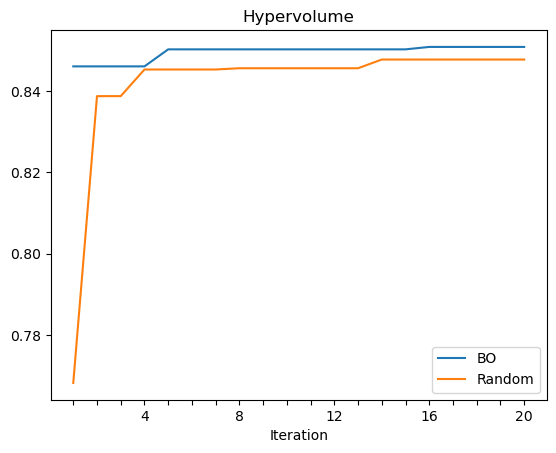

In [93]:
plt.figure()
plt.plot(experiment_results[0, 0, :], label='BO')
plt.plot(experiment_results[1, 0, :], label='Random')
plt.xticks(np.arange(20), labels=[str(i+1) if (i+1) % 4 == 0 else '' for i in range(20)])
plt.legend()
plt.title('Hypervolume')
plt.xlabel('Iteration')
plt.show()

In [95]:
best_conf = experiment_configurations[0, 0, 19, :]

lr = 10 ** - (1 + 3 * best_conf[0])
dropout = best_conf[1]

print(f'lr:      {lr:>5.5f}')
print(f'dropout: {dropout:>5.5f}')

lr:      0.03086
dropout: 0.34259


<br><br><br>

# Bayesian Optimization: Online tutorial

### Imports

In [ ]:
import botorch
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP

from gpytorch.mlls import MarginalLogLikelihood

from botorch.test_functions.multi_objective import BraninCurrin


### Problem setup

In [23]:
tkwargs = {'dtype': torch.double}

import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")

from botorch.test_functions.multi_objective import BraninCurrin
problem = BraninCurrin(negate=True).to(**tkwargs)

### Model initialization

In [21]:
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.sampling import draw_sobol_samples

NOISE_SE = torch.tensor([15.19, 0.63], **tkwargs)

def generate_initial_data(n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds,n=n, q=1).squeeze(1)
    train_obj_true = problem(train_x)
    train_obj = train_obj_true + torch.randn_like(train_obj_true) * NOISE_SE
    return train_x, train_obj, train_obj_true


def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    train_x = normalize(train_x, problem.bounds)
    models = []
    for i in range(train_obj.shape[-1]):
        train_y = train_obj[..., i:i+1]
        train_yvar = torch.full_like(train_y, NOISE_SE[i] ** 2)
        models.append(
            FixedNoiseGP(train_x, train_y, train_yvar, outcome_transform=Standardize(m=1))
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model


### qEHVI

In [24]:
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement, qNoisyExpectedHypervolumeImprovement
from botorch.utils.sampling import sample_simplex


BATCH_SIZE = 4
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4

standard_bounds = torch.zeros(2, problem.dim, **tkwargs)
standard_bounds[1] = 1


def optimize_qehvi_and_get_observation(model, train_x, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    with torch.no_grad():
        pred = model.posterior(normalize(train_x, problem.bounds)).mean
    partitioning = FastNondominatedPartitioning(
        ref_point=problem.ref_point,
        Y=pred,
    )
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=problem.ref_point,
        partitioning=partitioning,
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    new_obj = new_obj_true + torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj, new_obj_true


### qNEHVI

In [25]:
def optimize_qnehvi_and_get_observation(model, train_x, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=problem.ref_point.tolist(),  # use known reference point
        X_baseline=normalize(train_x, problem.bounds),
        prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    new_obj = new_obj_true + torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj, new_obj_true

### qNParEGO

In [26]:
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement


def optimize_qnparego_and_get_observation(model, train_x, train_obj, sampler):
    """Samples a set of random weights for each candidate in the batch, performs sequential greedy optimization
    of the qNParEGO acquisition function, and returns a new candidate and observation."""
    train_x = normalize(train_x, problem.bounds)
    with torch.no_grad():
        pred = model.posterior(train_x).mean
    acq_func_list = []
    for _ in range(BATCH_SIZE):
        weights = sample_simplex(problem.num_objectives, **tkwargs).squeeze()
        objective = GenericMCObjective(get_chebyshev_scalarization(weights=weights, Y=pred))
        acq_func = qNoisyExpectedImprovement(  # pyre-ignore: [28]
            model=model,
            objective=objective,
            X_baseline=train_x,
            sampler=sampler,
            prune_baseline=True,
        )
        acq_func_list.append(acq_func)
    # optimize
    candidates, _ = optimize_acqf_list(
        acq_function_list=acq_func_list,
        bounds=standard_bounds,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x =  unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    new_obj = new_obj_true + torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj, new_obj_true


### Loop

In [30]:
import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
from botorch.utils.multi_objective.pareto import is_non_dominated


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

N_BATCH = 20 if not SMOKE_TEST else 10
MC_SAMPLES = 128 if not SMOKE_TEST else 16

verbose = True

hvs_qparego, hvs_qehvi, hvs_qnehvi, hvs_random = [], [], [], []

# call helper functions to generate initial training data and initialize model
train_x_qparego, train_obj_qparego, train_obj_true_qparego = generate_initial_data(
    n=2 * (problem.dim + 1)
)
mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego)

train_x_qehvi, train_obj_qehvi, train_obj_true_qehvi = (
    train_x_qparego,
    train_obj_qparego,
    train_obj_true_qparego,
)
train_x_qnehvi, train_obj_qnehvi, train_obj_true_qnehvi = (
    train_x_qparego,
    train_obj_qparego,
    train_obj_true_qparego,
)
train_x_random, train_obj_random, train_obj_true_random = (
    train_x_qparego,
    train_obj_qparego,
    train_obj_true_qparego,
)
mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)
mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_qnehvi)

# compute hypervolume
bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_qparego)
volume = bd.compute_hypervolume().item()

hvs_qparego.append(volume)
hvs_qehvi.append(volume)
hvs_qnehvi.append(volume)
hvs_random.append(volume)

# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in range(1, N_BATCH + 1):

    t0 = time.monotonic()

    # fit the models
    fit_gpytorch_mll(mll_qparego)
    fit_gpytorch_mll(mll_qehvi)
    fit_gpytorch_mll(mll_qnehvi)

    # define the qEI and qNEI acquisition modules using a QMC sampler
    qparego_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
    qehvi_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
    qnehvi_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    # optimize acquisition functions and get new observations
    (
        new_x_qparego,
        new_obj_qparego,
        new_obj_true_qparego,
    ) = optimize_qnparego_and_get_observation(
        model_qparego, train_x_qparego, train_obj_qparego, qparego_sampler
    )
    new_x_qehvi, new_obj_qehvi, new_obj_true_qehvi = optimize_qehvi_and_get_observation(
        model_qehvi, train_x_qehvi, train_obj_qehvi, qehvi_sampler
    )
    (
        new_x_qnehvi,
        new_obj_qnehvi,
        new_obj_true_qnehvi,
    ) = optimize_qnehvi_and_get_observation(
        model_qnehvi, train_x_qnehvi, train_obj_qnehvi, qnehvi_sampler
    )
    new_x_random, new_obj_random, new_obj_true_random = generate_initial_data(
        n=BATCH_SIZE
    )

    # update training points
    train_x_qparego = torch.cat([train_x_qparego, new_x_qparego])
    train_obj_qparego = torch.cat([train_obj_qparego, new_obj_qparego])
    train_obj_true_qparego = torch.cat([train_obj_true_qparego, new_obj_true_qparego])

    train_x_qehvi = torch.cat([train_x_qehvi, new_x_qehvi])
    train_obj_qehvi = torch.cat([train_obj_qehvi, new_obj_qehvi])
    train_obj_true_qehvi = torch.cat([train_obj_true_qehvi, new_obj_true_qehvi])

    train_x_qnehvi = torch.cat([train_x_qnehvi, new_x_qnehvi])
    train_obj_qnehvi = torch.cat([train_obj_qnehvi, new_obj_qnehvi])
    train_obj_true_qnehvi = torch.cat([train_obj_true_qnehvi, new_obj_true_qnehvi])

    train_x_random = torch.cat([train_x_random, new_x_random])
    train_obj_random = torch.cat([train_obj_random, new_obj_random])
    train_obj_true_random = torch.cat([train_obj_true_random, new_obj_true_random])

    # update progress
    for hvs_list, train_obj in zip(
        (hvs_random, hvs_qparego, hvs_qehvi, hvs_qnehvi),
        (
            train_obj_true_random,
            train_obj_true_qparego,
            train_obj_true_qehvi,
            train_obj_true_qnehvi,
        ),
    ):
        # compute hypervolume
        bd = DominatedPartitioning(ref_point=problem.ref_point, Y=train_obj)
        volume = bd.compute_hypervolume().item()
        hvs_list.append(volume)

    # reinitialize the models so they are ready for fitting on next iteration
    # Note: we find improved performance from not warm starting the model hyperparameters
    # using the hyperparameters from the previous iteration
    mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego)
    mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)
    mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi, train_obj_qnehvi)

    t1 = time.monotonic()

    if verbose:
        print(
            f"\nBatch {iteration:>2}: Hypervolume (random, qNParEGO, qEHVI, qNEHVI) = "
            f"({hvs_random[-1]:>4.2f}, {hvs_qparego[-1]:>4.2f}, {hvs_qehvi[-1]:>4.2f}, {hvs_qnehvi[-1]:>4.2f}), "
            f"time = {t1-t0:>4.2f}.",
            end="",
        )
    else:
        print(".", end="")


ImportError: cannot import name 'fit_gpytorch_mllaasd' from 'botorch' (C:\Users\jorge\AppData\Local\Continuum\anaconda3\lib\site-packages\botorch\__init__.py)

### Plot

In [32]:
botorch.__version__

'0.6.6'

# OLD

In [240]:
def multi_objective_optimization(num_restarts=10):
    X = torch.rand(10, 2) # Initialize random points

    accs = []
    for row in X:
        n1 = int(row[0])
        n2 = int(row[1])
        model = create_and_train_model(n1, n2)
        accs.append(objective_accuracy(model))
    Y_acc = torch.tensor(accs)

    # Y = torch.stack([model_accuracy(X), fairness_metric(X)], dim=-1) # Evaluate functions
    gpytorch_model = SingleTaskGP(X, Y_acc)

    fit_gpytorch_model(gpytorch_model, options={'max_restarts': num_restarts})

    acquisition = MarginalLogLikelihood(gpytorch_model, num_restarts=num_restarts)

    candidate, _ = botorch.optimize(acquisition, bounds=bounds, q=1, num_restarts=num_restarts, raw_samples=100)

    return candidate

In [241]:
bounds = torch.stack([torch.zeros(2), torch.ones(2)], dim=0)